### Next steps (10/09)

1. Understand difference between reduced form and adjacency matrix.
    
2. Sample abstraction tau T (given omega?).

3. Save/Load model logic 

4. CVXPY implementation

In [5]:
import random
import itertools
import joblib
import pickle 
import os
import cvxpy

from itertools import chain, combinations
from typing import Optional
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LinearRegression

from scipy.stats import wasserstein_distance
from scipy.stats import norm
from scipy.stats import wishart
import networkx as nx
import matplotlib.pyplot as plt

from scipy.linalg import sqrtm
from scipy.special import rel_entr
from scipy.spatial.distance import jensenshannon

from src.CBN import CausalBayesianNetwork as CBN
import modularised_utils as mut
import Linear_Additive_Noise_Models as lanm
import operations as ops

import params

np.random.seed(0)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/giofelekis/opt/anaconda3/envs/erica/lib/python3.12/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/giofelekis/opt/anaconda3/envs/erica/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/giofelekis/opt/anaconda3/envs/erica/lib/python3.12/site-packages/ipykernel/kernelapp.py", lin

### Define low-level DCM "LL" and high-level DCM "HL"

In [6]:
experiment = 'synth1'


In [7]:
S = 'Smoking'
T = 'Tar'
C = 'Cancer'

S_ = 'Smoking_'
C_ = 'Cancer_'

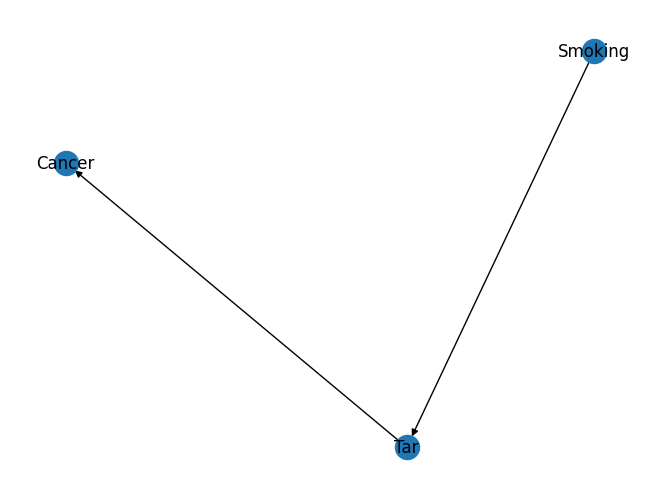

In [8]:
ll_endogenous_coeff_dict = {(S, T): 0.3, (T, C): 0.2}
ll_causal_graph          = CBN(list(ll_endogenous_coeff_dict.keys()))
nx.draw(nx.DiGraph(ll_causal_graph.edges()),with_labels=True)

hl_endogenous_coeff_dict = {(S_, C_): 0.6}
hl_causal_graph          = CBN(list(hl_endogenous_coeff_dict.keys()))
#nx.draw(nx.DiGraph(hl_causal_graph.edges()),with_labels=True)

### Construct the empirical nominal distribution/ environment
This should be later infered from the endogenous samples (with or without abduction)

In [4]:
ll_mu_hat       = np.array([0, 0, 0])  
ll_Sigma_hat    = np.diag([1, 2, 1]) 


hl_mu_hat       = np.array([0, 0])  
hl_Sigma_hat    = np.diag([1, 1])

### Define the sets of relevant interventions and the (total) surjective and order-preserving function $ω:I^{L} \mapsto I^{H}$

In [5]:
iota0 = None
iota1 = ops.Intervention({S:0})
iota2 = ops.Intervention({S:0, T:1})
iota3 = ops.Intervention({S:1})
iota4 = ops.Intervention({S:1, T:0})
iota5 = ops.Intervention({S:1, T:1})

eta0 = None
eta1 = ops.Intervention({S_:0})
eta2 = ops.Intervention({S_:1})

omega = {   
            iota0: eta0,
            iota1: eta1,
            iota2: eta1,
            iota3: eta2,
            iota4: eta2,
            iota5: eta2
        }

Ill_relevant = list(set(omega.keys()))
Ihl_relevant = list(set(omega.values()))

### Construct the Ambiguity sets

In [7]:
# Define the radius of the Wasserstein balls (epsilon, delta) and the size for both models.
epsilon         = params.radius[experiment][0]
ll_num_envs     = params.n_envs[experiment][0]

delta           = params.radius[experiment][1]
hl_num_envs     = params.n_envs[experiment][1]

# Define the number of samples per environment. Currently every environment has the same number of samples
num_llsamples   = params.n_samples[experiment][0]
num_hlsamples   = params.n_samples[experiment][1]

distance_err    = 'wass'

In [8]:
# Ambiguity set construction: Based on epsilon and delta include distribution (as many as the num_envs) that
# pass the "gelbrich" test.
ll_moments = mut.sample_moments_U(mu_hat    = ll_mu_hat,
                                  Sigma_hat = ll_Sigma_hat,
                                  bound     = epsilon,
                                  num_envs  = ll_num_envs)

A_ll       = mut.sample_distros_Gelbrich(ll_moments) #Low-level: A_epsilon


hl_moments = mut.sample_moments_U(mu_hat    = hl_mu_hat,
                                  Sigma_hat = hl_Sigma_hat,
                                  bound     = delta,
                                  num_envs  = hl_num_envs)

A_hl       = mut.sample_distros_Gelbrich(hl_moments) #High-level A_delta

In [9]:
abstraction_errors             = {}
abstraction_env_errors         = {}
max_env_avg_interv_error_value = -np.inf
max_env_avg_interv_error_key   = None

for lenv in A_ll:

    Dll_noise      = lenv.sample(num_llsamples)[0]
    ll_environment = mut.get_exogenous_distribution(Dll_noise)

    LLmodels, Dll_samples = {}, {}
    for iota in Ill_relevant:

        LLmodels[iota]      = lanm.LinearAddSCM(ll_causal_graph, ll_endogenous_coeff_dict, iota)
        Dll_samples[iota]   = LLmodels[iota].sample_settings(Dll_noise)

    for henv in A_hl:
        Dhl_noise      = henv.sample(num_hlsamples)[0]
        hl_environment = mut.get_exogenous_distribution(Dhl_noise)

        HLmodels, Dhl_samples = {}, {}
        for eta in Ihl_relevant:

            HLmodels[eta]      = lanm.LinearAddSCM(hl_causal_graph, hl_endogenous_coeff_dict, eta)
            Dhl_samples[eta]   = HLmodels[eta].sample_settings(Dhl_noise)


        pairs = mut.create_pairs(Ill_relevant, omega, LLmodels, HLmodels)

        total_ui_error = 0
        num_distros    = len(pairs)

        n, m  = len(LLmodels[None].endogenous_vars), len(HLmodels[None].endogenous_vars)

        T     = mut.sample_stoch_matrix(n, m) #np.random.rand(n, m) #sample_abstraction(LLmodels, HLmodels)

        for iota in Ill_relevant:
            llcm   = LLmodels[iota]
            hlcm   = HLmodels[omega[iota]]
            llmech = llcm.compute_mechanism()
            hlmech = hlcm.compute_mechanism()
            #error = mut.ui_error_dist(distance_err, ll_environment, hl_environment, llmech, hlmech, T)
            error = mut.ui_error_dist(distance_err, lenv, henv, llmech, hlmech, T)

            total_ui_error += error

        avg_interv_error = total_ui_error/num_distros

        if avg_interv_error > max_env_avg_interv_error_value:
            max_env_avg_interv_error_value = avg_interv_error
            max_env_avg_interv_error_key   = (lenv, henv)

        abstraction_errors[str(T)] = avg_interv_error
        abstraction_env_errors['ll: '+str(ll_environment.means_)+' hl: '+str(hl_environment.means_)] = avg_interv_error

/Users/giofelekis/opt/anaconda3/lib/python3.9/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [10]:
max_tau   = max(abstraction_errors, key=abstraction_errors.get)
max_error = abstraction_errors[max_tau]

print(f"Abstraction: {max_tau}, Error: {max_error}")
print('==============================================================================' )
max_lenv = max_env_avg_interv_error_key[0]
max_henv = max_env_avg_interv_error_key[1]

print(f"max LL mean vector = {max_lenv.means_}")
print(f"max LL covariance = {max_lenv.covariances_}")
print( )

print(f"max HL mean vector = {max_henv.means_}")
print(f"max HL covariance = {max_henv.covariances_}")
print('==============================================================================' )
print(f"max environment, average interventional abstraction error = {max_env_avg_interv_error_value}")

Abstraction: [[0.27398458 0.72601542]
 [0.41617667 0.58382333]
 [0.23448161 0.76551839]], Error: 1.0887962854471707
max LL mean vector = [[0.04438632 0.03336743 0.14940791]]
max LL covariance = [[[0.84730977 0.         0.        ]
  [0.         2.05596841 0.        ]
  [0.         0.         0.85734131]]]

max HL mean vector = [[-0.02051583  0.00334389]]
max HL covariance = [[[0.96586478 0.        ]
  [0.         0.90582224]]]
max environment, average interventional abstraction error = 1.0887962854471707


In [ ]:
for lenv in A_ll:

    Dll_noise      = lenv.sample(num_llsamples)[0]
    ll_environment = mut.get_exogenous_distribution(Dll_noise)

    for henv in A_hl:
        Dhl_noise      = henv.sample(num_hlsamples)[0]
        hl_environment = mut.get_exogenous_distribution(Dhl_noise)
        
        print((ll_environment, hl_environment))
        
        total_ui_error = 0
        num_distros    = len(Ill)
        
        n, m  = len(LLmodels[None].endogenous_vars), len(HLmodels[None].endogenous_vars)
        T     = mut.sample_stoch_matrix(n, m) 
        
        for iota in Ill:
            llcm   = LLmodels[iota]
            hlcm   = HLmodels[omega[iota]]
            llmech = llcm.compute_mechanism()
            hlmech = hlcm.compute_mechanism()
            error  = mut.ui_error_dist(distance_err, lenv, henv, llmech, hlmech, T)

            total_ui_error += error

        avg_interv_error = total_ui_error/num_distros

In [11]:
abstraction_errors             = {}
abstraction_env_errors         = {}
max_env_avg_interv_error_value = -np.inf
max_env_avg_interv_error_key   = None

for lenv in A_ll:

    Dll_noise      = lenv.sample(num_llsamples)[0]
    ll_environment = mut.get_exogenous_distribution(Dll_noise)

    LLmodels, Dll_samples = {}, {}
    for iota in Ill_relevant:

        LLmodels[iota]      = lanm.LinearAddSCM(ll_causal_graph, ll_endogenous_coeff_dict, iota)
        Dll_samples[iota]   = LLmodels[iota].sample_settings(Dll_noise)

    for henv in A_hl:
        Dhl_noise      = henv.sample(num_hlsamples)[0]
        hl_environment = mut.get_exogenous_distribution(Dhl_noise)

        HLmodels, Dhl_samples = {}, {}
        for eta in Ihl_relevant:

            HLmodels[eta]      = lanm.LinearAddSCM(hl_causal_graph, hl_endogenous_coeff_dict, eta)
            Dhl_samples[eta]   = HLmodels[eta].sample_settings(Dhl_noise)


        pairs = mut.create_pairs(Ill_relevant, omega, LLmodels, HLmodels)

        total_i_error = 0
        num_distros   = len(pairs)

        n, m  = len(LLmodels[None].endogenous_vars), len(HLmodels[None].endogenous_vars)

        T     = mut.sample_stoch_matrix(n, m) #np.random.rand(n, m) #sample_abstraction(LLmodels, HLmodels)

        for iota in Ill_relevant:
            llcm   = LLmodels[iota]
            hlcm   = HLmodels[omega[iota]]
            llmech = llcm.compute_mechanism()
            hlmech = hlcm.compute_mechanism()
            dllcm  = mut.get_endogenous_distribution(Dll_samples[iota])
            dhlcm  = mut.get_endogenous_distribution(Dhl_samples[omega[iota]]) 
            error = mut.i_error_dist(distance_err, dllcm, dhlcm, T)

            total_i_error += error

        avg_interv_error = total_i_error/num_distros

        if avg_interv_error > max_env_avg_interv_error_value:
            max_env_avg_interv_error_value = avg_interv_error
            max_env_avg_interv_error_key   = (lenv, henv)

        abstraction_errors[str(T)] = avg_interv_error
        abstraction_env_errors['ll: '+str(ll_environment.means_)+' hl: '+str(hl_environment.means_)] = avg_interv_error

In [12]:
max_tau   = max(abstraction_errors, key=abstraction_errors.get)
max_error = abstraction_errors[max_tau]

print(f"Abstraction: {max_tau}, Error: {max_error}")
print('==============================================================================' )
max_lenv = max_env_avg_interv_error_key[0]
max_henv = max_env_avg_interv_error_key[1]

print(f"max LL mean vector = {max_lenv.means_}")
print(f"max LL covariance = {max_lenv.covariances_}")
print( )

print(f"max HL mean vector = {max_henv.means_}")
print(f"max HL covariance = {max_henv.covariances_}")
print('==============================================================================' )
print(f"max environment, average interventional abstraction error = {max_env_avg_interv_error_value}")

Abstraction: [[0.00734027 0.99265973]
 [0.19427353 0.80572647]
 [0.23078559 0.76921441]], Error: 3.083806808649351
max LL mean vector = [[0.04438632 0.03336743 0.14940791]]
max LL covariance = [[[0.84730977 0.         0.        ]
  [0.         2.05596841 0.        ]
  [0.         0.         0.85734131]]]

max HL mean vector = [[-0.02051583  0.00334389]]
max HL covariance = [[[0.96586478 0.        ]
  [0.         0.90582224]]]
max environment, average interventional abstraction error = 3.083806808649351
